In [1]:
import builtins
import os
import pickle
import time
import pylab
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed
import os
from PIL import Image
from tensorflow import keras
from keras.layers import *

Свёрточные слои являются основным строительным блоком свёрточных нейронных сетей (Convolutional Neural Networks, CNN), которые широко применяются для обработки и анализа изображений. Работа свёрточных слоев основана на использовании операции свёртки, которая позволяет извлекать локальные особенности изображения.

Каждый свёрточный слой состоит из набора фильтров или ядер свёртки. Каждое ядро представляет собой небольшую матрицу весов, которая перемещается по изображению с определенным шагом. В процессе свёртки, каждое ядро последовательно перемещается по изображению, и на каждом шаге производится покомпонентное перемножение значений ядра с соответствующими пиксельными значениями в текущем окне изображения. Результаты умножений суммируются, и полученное значение записывается в новую матрицу, называемую картой признаков или feature map.

Суть операции свёртки заключается в поиске локальных паттернов или признаков в изображении. Каждое ядро свёртки специализируется на обнаружении конкретного паттерна, например, вертикальных граней, горизонтальных граней, текстур и т. д. Путем обучения нейронной сети оптимизируются веса внутри ядер свёртки для эффективного извлечения паттернов изображения.

После прохождения свёрточного слоя, получается новая матрица меньшего размера, которая состоит из извлеченных локальных паттернов или признаков. Это достигается за счет использования окна с определенным шагом при свёртке, что приводит к уменьшению пространственного размера данных. Вместо полного соединения каждого пикселя с каждым пикселем входного изображения, свёрточный слой фокусируется на локальных областях и извлекает наиболее информативные признаки.

Процесс свёртки и последующее уменьшение размерности обычно повторяются несколько раз в свёрточной нейронной сети. При этом, количество ядер свёртки обычно увеличивается с каждым последующим слоем, что позволяет извлекать все более абстрактные и сложные признаки изображения.

Таким образом, свёрточные слои в свёрточных нейронных сетях играют важную роль в извлечении иерархических признаков из изображений, постепенно улучшая представление данных для более высокоуровневых задач, таких как классификация изображений или обнаружение объектов.

Загрузка датасет

In [ ]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

!ls

Просмотр фотографий в директории

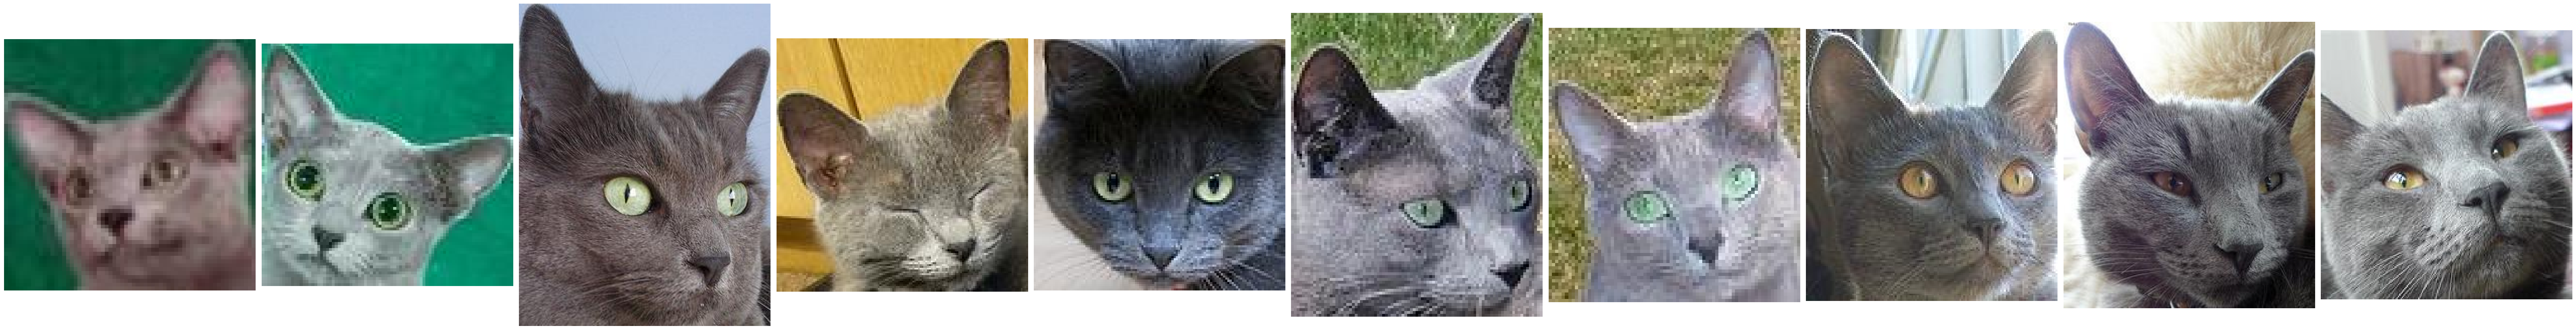

In [2]:
def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images([Image.open('petfaces/cat_Russian/' + filename) for filename in os.listdir('petfaces/cat_Russian')[:10]])

Займёмся определением породы.
Разделим датасет на тренировочный и тестовый, а также приведём фотографии к единому размеру

In [3]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

dataset_dir = 'petfaces'

images_2 = []
targets_2 = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        image_2 = Image.open(file_path)
        image_2 = image_2.resize((128, 128))
        image_array = np.array(image_2)
        
        images_2.append(image_array)
        targets_2.append(folder)
        
images_2 = np.array(images_2)
targets_2 = np.array(targets_2)

train_images, test_images, train_targets, test_targets = train_test_split(images_2, targets_2, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_targets_encoded = label_encoder.fit_transform(train_targets)
test_targets_encoded = label_encoder.transform(test_targets)

Определим и скомпилируем модель нейронной сети для обработки изображений пород с использованием библиотеки Keras.

In [4]:
model = keras.models.Sequential()
model.add(Conv2D(filters = 8, kernel_size=5, strides=1, activation = 'relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(filters = 16, kernel_size=5, strides=1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(filters = 32, kernel_size=5, strides=1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(filters = 64, kernel_size=5, strides=1, activation = 'relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dense(220,activation='relu'))
model.add(Dense(35,activation='softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        12832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 32)       0

Обучаем модель на 10 эпохах

In [5]:
hist = model.fit(train_images, train_targets_encoded, validation_data=(test_images, test_targets_encoded), epochs=10)

Epoch 1/10
81/81 [==============================] - 14s 160ms/step - loss: 6.3316 - accuracy: 0.0506 - val_loss: 3.4281 - val_accuracy: 0.0715
Epoch 2/10
81/81 [==============================] - 13s 155ms/step - loss: 3.2356 - accuracy: 0.1110 - val_loss: 3.0475 - val_accuracy: 0.1586
Epoch 3/10
81/81 [==============================] - 12s 150ms/step - loss: 2.8029 - accuracy: 0.2150 - val_loss: 2.7343 - val_accuracy: 0.2255
Epoch 4/10
81/81 [==============================] - 13s 162ms/step - loss: 2.3768 - accuracy: 0.3228 - val_loss: 2.5266 - val_accuracy: 0.2955
Epoch 5/10
81/81 [==============================] - 13s 156ms/step - loss: 2.0341 - accuracy: 0.4190 - val_loss: 2.3708 - val_accuracy: 0.3453
Epoch 6/10
81/81 [==============================] - 12s 143ms/step - loss: 1.7563 - accuracy: 0.4864 - val_loss: 2.5725 - val_accuracy: 0.3344
Epoch 7/10
81/81 [==============================] - 12s 146ms/step - loss: 1.4875 - accuracy: 0.5619 - val_loss: 2.3420 - val_accuracy: 0.3686

Выполним итерацию по парам изображений и соответствующих закодированных целевых меток.

In [6]:
for x, targets in zip(test_images, test_targets_encoded):
    print(targets)
    

7
24
33
27
16
20
8
26
7
17
2
11
34
28
12
28
13
14
30
10
19
1
2
15
4
12
9
0
8
20
16
17
30
0
32
12
2
34
18
27
16
7
13
18
3
4
0
20
32
5
9
19
28
29
33
22
25
11
16
33
15
11
6
2
16
26
2
11
32
1
7
5
2
9
16
19
33
6
10
13
25
3
12
4
10
11
1
31
6
17
12
26
17
23
33
13
32
12
15
6
23
20
23
7
32
20
4
5
6
32
33
25
28
11
18
1
27
8
3
2
18
15
9
23
8
2
4
2
9
6
13
20
1
17
31
2
14
11
10
2
0
28
4
7
25
0
24
9
6
2
15
12
6
25
30
26
12
14
33
3
3
3
28
17
14
5
12
24
16
19
24
12
3
4
11
13
0
31
7
0
7
4
0
31
25
3
13
31
27
34
2
18
2
3
1
12
2
10
29
0
26
24
23
17
17
3
2
10
9
9
13
29
12
27
32
23
21
20
13
6
11
21
23
27
16
28
11
6
27
5
18
31
31
15
2
20
15
30
4
33
0
17
3
7
1
2
9
17
21
0
30
5
25
3
22
12
13
24
18
17
28
22
0
30
26
20
3
12
16
12
2
3
23
17
6
1
4
18
34
20
34
17
33
23
4
16
10
25
14
12
9
13
13
12
28
10
27
2
26
13
21
14
4
12
13
14
20
2
7
12
12
26
6
29
17
11
10
9
3
23
6
22
16
17
19
9
30
34
30
2
33
12
11
18
19
16
33
25
32
31
4
15
17
19
15
24
10
20
28
12
20
3
14
30
23
3
14
2
8
0
3
18
10
12
11
12
7
7
26
4
4
0
8
11
20
5


Вычислим точность предсказаний модели, подсчитывая долю правильных предсказаний по сравнению с истинными метками 

In [7]:
pred = model.predict(test_images)
reduce_sum = tf.reduce_sum(tf.cast(tf.math.in_top_k(test_targets_encoded, pred, k=5), dtype=tf.int32)) / len(test_targets_encoded)
print(reduce_sum)

21/21 [==============================] - 1s 26ms/step
tf.Tensor(0.6936236391912908, shape=(), dtype=float64)


Посчитаем матрицу

In [8]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

confusion_mat = confusion_matrix(test_targets_encoded, predicted_labels)
print(confusion_mat)

21/21 [==============================] - 1s 27ms/step
[[ 4  7  0 ...  0  1  0]
 [ 1 10  0 ...  0  0  1]
 [ 1  0 15 ...  1  0  0]
 ...
 [ 0  3  0 ...  2  0  0]
 [ 0  1  0 ...  0  6  1]
 [ 0  1  0 ...  0  1  3]]


Создадим две директории для собак и кошек и отсортируем в нее из директории "petfaces"

In [ ]:
import os
import shutil

# Создание директории для нового датасета
if not os.path.exists('binary_dataset'):
    os.makedirs('binary_dataset')
    
# Создание директорий для котов и собак
for animal in ['cat', 'dog']:
    animal_dir = os.path.join('binary_dataset', animal)
    if not os.path.exists(animal_dir):
        os.makedirs(animal_dir)

# Копирование изображений котов и собак в соответствующие директории
for folder in os.listdir('petfaces'):
    if folder.startswith('cat'):
        for file in os.listdir(os.path.join('petfaces', folder)):
            shutil.copy(os.path.join('petfaces', folder, file), os.path.join('binary_dataset', 'cat', file))
    elif folder.startswith('dog'):
        for file in os.listdir(os.path.join('petfaces', folder)):
            shutil.copy(os.path.join('petfaces', folder, file), os.path.join('binary_dataset', 'dog', file))

Для бинарной классификации создадим датасет из классов кошек и собак

In [9]:
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split

dataset_dir = 'binary_dataset'

images_1 = []
targets_1 = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        image_1 = Image.open(file_path)
        image_1 = image_1.resize((128, 128))
        image_array = np.array(image_1)
        
        images_1.append(image_array)
        if 'dog' in folder:
            targets_1.append(1) 
        elif 'cat' in folder:
            targets_1.append(0) 
        
images_1 = np.array(images_1)
targets_1 = np.array(targets_1)

train_images_1, test_images_1, train_targets_1, test_targets_1 = train_test_split(images_1, targets_1, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_targets_encoded_1 = label_encoder.fit_transform(train_targets_1)
test_targets_encoded_1 = label_encoder.transform(test_targets_1)


Определим и скомпилируем модель нейронной сети для обработки бинарной классификации кошк и собак с использованием библиотеки Keras.

In [10]:
model = keras.models.Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(128,128,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5, 5), activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', ['accuracy'])

hist = model.fit(train_images_1, train_targets_encoded_1, epochs=10)

Epoch 1/10
81/81 [==============================] - 35s 424ms/step - loss: 2.1304 - accuracy: 0.7333
Epoch 2/10
81/81 [==============================] - 33s 408ms/step - loss: 0.3522 - accuracy: 0.8438
Epoch 3/10
81/81 [==============================] - 33s 408ms/step - loss: 0.2548 - accuracy: 0.9026
Epoch 4/10
81/81 [==============================] - 35s 431ms/step - loss: 0.1885 - accuracy: 0.9287
Epoch 5/10
81/81 [==============================] - 33s 411ms/step - loss: 0.1376 - accuracy: 0.9467
Epoch 6/10
81/81 [==============================] - 32s 389ms/step - loss: 0.1085 - accuracy: 0.9591
Epoch 7/10
81/81 [==============================] - 33s 408ms/step - loss: 0.0711 - accuracy: 0.9751
Epoch 8/10
81/81 [==============================] - 33s 407ms/step - loss: 0.0528 - accuracy: 0.9868
Epoch 9/10
81/81 [==============================] - 32s 389ms/step - loss: 0.0598 - accuracy: 0.9766
Epoch 10/10
81/81 [==============================] - 32s 400ms/step - loss: 0.0356 - accura

Посчитаем матрицу ошибок для бинарной классификации

In [11]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_images_1)
test_predictions = (test_predictions > 0.5).astype(int)
confusion_mtx = confusion_matrix(test_targets_encoded_1, test_predictions)
print(confusion_mtx)

21/21 [==============================] - 1s 57ms/step
[[194  52]
 [ 23 374]]
